# Стартапы

## 0.Описание проекта

### 0.1.Задача проекта

Разработать модель для предсказания успешности стартапа (закроется или нет)

### 0.2.Описание данных

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Наша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
 - kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

### 0.3.Описание полей данных

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

### 0.4.План выполения проекта

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

## 1. Загрузка и подготовка данных

### 1.1. Чтение данных

In [312]:
# Установим необходимые библиотеки
!pip install phik
!pip install -U scikit-learn

In [399]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from datetime import datetime

from matplotlib.dates import DateFormatter, MonthLocator

from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, TargetEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import phik
import os

pd.set_option('display.float_format', '{:.2f}'.format)

In [314]:
RANDOM_STATE = 42

In [315]:
sample_submit = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
test = pd.read_csv('kaggle_startups_test_28062024.csv')
train = pd.read_csv('kaggle_startups_train_28062024.csv')

In [316]:
# Проверим размеры получившихся датасетов
print(sample_submit.shape)
print(test.shape)
print(train.shape)

(13125, 2)
(13125, 11)
(52516, 13)


### 1.2. Изучение общей информации о датасетах

In [317]:
# Создадим функцию для просмотра общей информации о датасетах
def overview_data(data):
    dash = '-' * 50

    print(dash)
    print('Основная информация о данных')
    print(dash)
    print(data.info())
    print('\n')

    print(dash)
    print('Первые строки данных')
    print(dash)
    print(data.head())
    print('\n')

    print(dash)
    print('Описательная статистика')
    print(dash)
    print(data.describe())
    print('\n')

    print(dash)
    print('Пропущенные значения')
    print(dash)
    print(data.isna().sum())
    print('\n')

    print(dash)
    print('Дубликаты')
    print(dash)
    print(data.duplicated().sum())
    print('\n')

In [318]:
# Выведем общую информацию о датасете train
overview_data(train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)

In [319]:
# Выведем общую информацию о датасете train
overview_data(test)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB
None


--------------------------------------------------
Первые строки да

In [320]:
overview_data(sample_submit)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB
None


--------------------------------------------------
Первые строки данных
--------------------------------------------------
                     name     status
0              Crystalsol     closed
1        JBI Fish & Wings  operating
2                COINPLUS     closed
3  Imagine Communications     closed
4                   DNA13  operating


--------------------------------------------------
Описательная статистика
--------------------------------------------------
              name     status
count        13125      13125
unique       13125          2
top  

### Вывод

Датасет train
- в колонках funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, status пропусков нет
- в колонке name один пропуск
- в остальных колонках от 2465 до 47599 пропусков
- пропуски в колоне closed_at скорее всего вызваны тем что стартап все еще существует или тем, что он существовал на момент акутализации данных
- пропуски в колонке funding_total_usd скорее всего вызваны тем что финансирования не было
- в колонках с датами не верный формат данных object
- в колонке funding_total_usd можно изменить формат на int т.к. думаю что центы в сумме финансирования не влияют на сумму
- явных дубликатов нет

Датасет test
- в колонках funding_rounds, first_funding_at, last_funding_at, status, name пропусков нет
- в остальных колонках от 591 до 2578 пропусков
- есть колонка lifetime - срок жизни стартапа, эту колонку нужно будет добавить в датасет train
- нет колонок founded_at и closed_at они заменены колонкой lifetime
- явных дубликатов нет

## 2. Анализ признаков

### 2.1. Анализ числовых признаков

In [321]:
# Функция построения диаграмм для числовых признаков
def num_diag(data, x, xlabel, ylabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat="density",
        bins=20,
        common_norm=False
    )
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма размаха {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [322]:
# Функция построения диаграмм для категориальных признаков
def cat_diag(data, x, xlabel, hue=None, threshold=0.015):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts < threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)

    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index
    )
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    pie_data = data_modified[x].value_counts(normalize=True)

    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False
    )
    axes[1].set_title(f'Распределение долей {xlabel}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [323]:
# Создадим функцию для автоматической визуализации признаков в зависимости от типа колонки
def all_diag(df, column_type='numeric', hue=None):
    if column_type == 'numeric':
        columns = df.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = df.select_dtypes(include='object').columns

    for col in columns:
        if column_type == 'numeric':
            print(f"Визуализация численного признака: {col}")
            num_diag(df, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f"Визуализация категориального признака: {col}")
            cat_diag(df, x=col, xlabel=col, hue=hue)

Визуализация численного признака: funding_total_usd


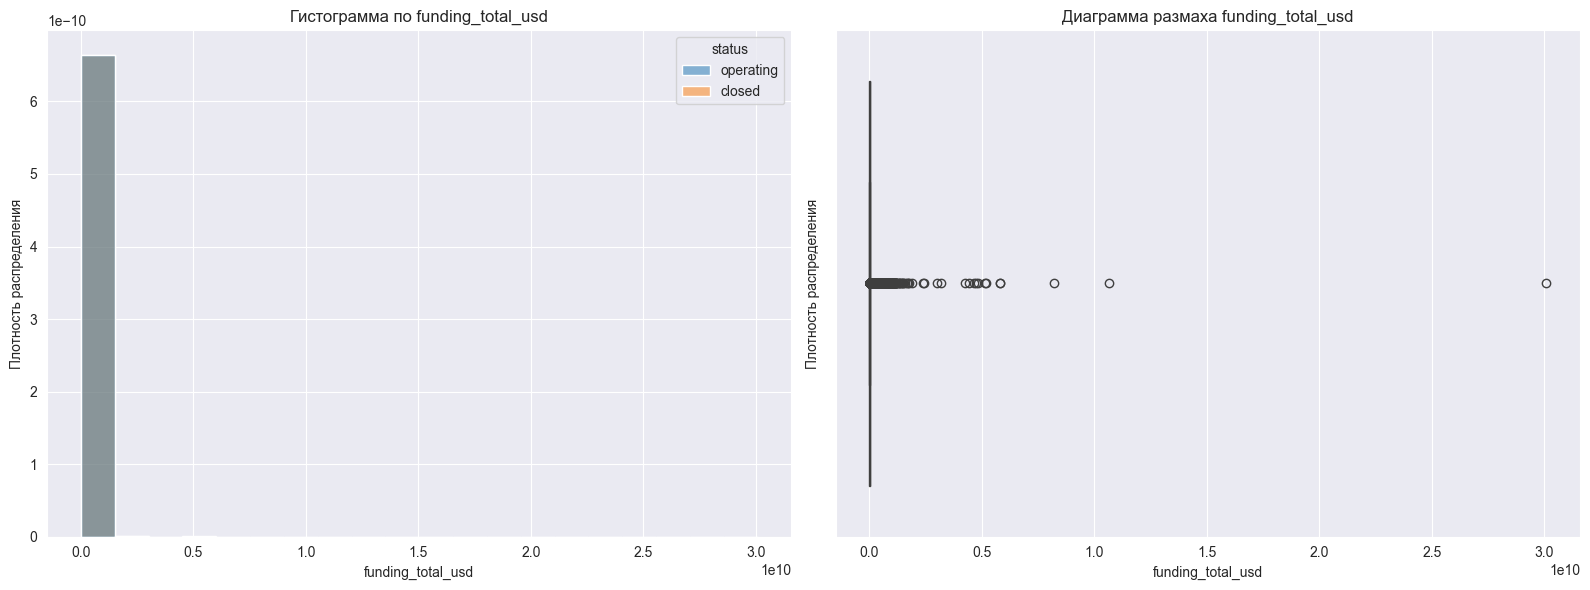

Визуализация численного признака: funding_rounds


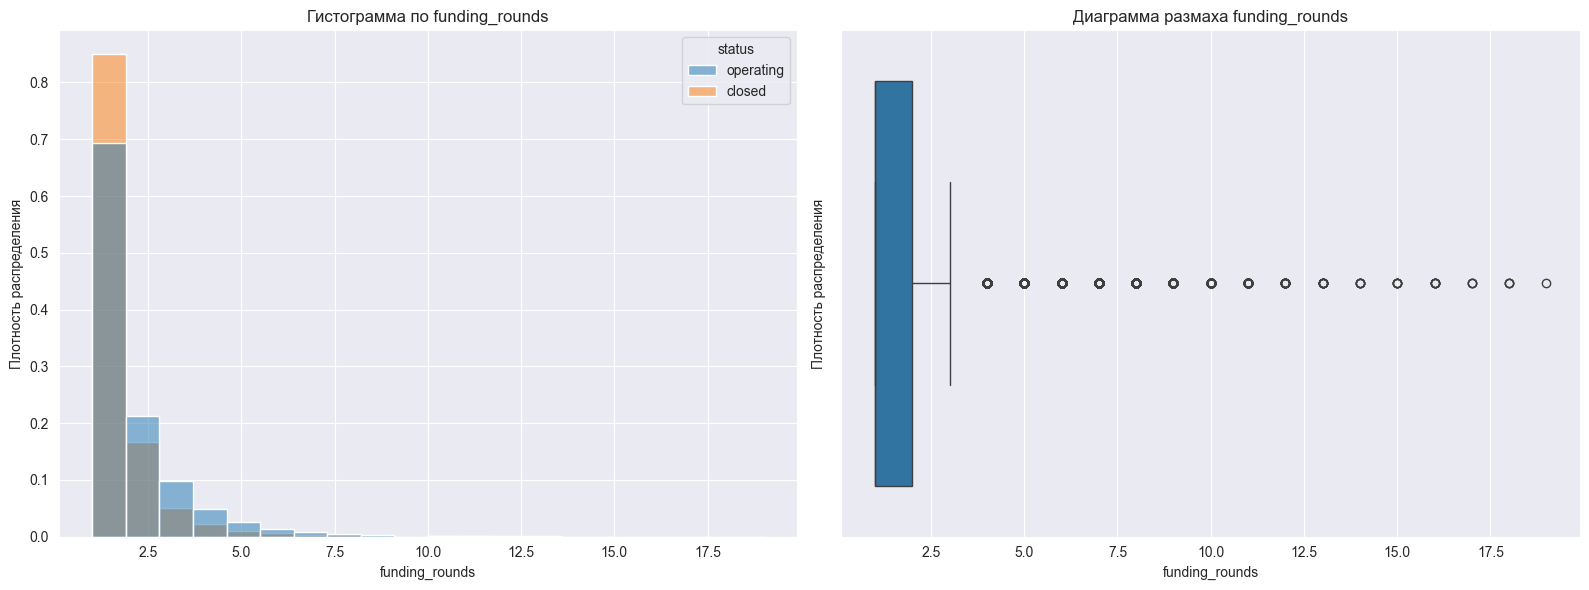

In [324]:
all_diag(train, column_type='numeric', hue='status')

In [325]:
train['funding_total_usd'].describe()

count         42447.00
mean       18247480.66
std       187117301.32
min               1.00
25%          336027.50
50%         2000000.00
75%        10000000.00
max     30079503000.00
Name: funding_total_usd, dtype: float64

funding_total_usd
- среднее значение финансирования составляет 18.2 млн.
- максимальное финансирование около 3 млрд. - думаю это реальное значение, было одно такое финасирование
- есть значение финансирования в 1 доллар
- большинство значений суммы финансирования находится в диапазоне между 336 тыс. и 10 млн

In [326]:
train['funding_rounds'].describe()

count   52516.00
mean        1.74
std         1.37
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        19.00
Name: funding_rounds, dtype: float64

funding_total_usd
- среднее значение раундов финансирования составляет 1.74 раунда
- максимальное количество раундов 19
- минимальное количество раундов 1
- большинство значений раундов финансирования 1-2 раунда, все что больше единичные значения
- закрытых проектов после 5-6 раундов финансирования практически нет, однако и проектов с таким количеством финанирования тоже практически нет.

### 2.2. Анализ категориальных признаков

Подготовим данные к анализу

In [327]:
# Приведем все даты к нужному типу
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
train[date_cols] = train[date_cols].apply(pd.to_datetime, errors='coerce')

In [328]:
# Создадим столбцы с корневыми и конечными категориями
train['end_cat'] = train['category_list'].str.split('|').str[-1]
train['end_cat'] = train['end_cat'].fillna('other')
train['root_cat'] = train['category_list'].str.split('|').str[0]
train['root_cat'] = train['root_cat'].fillna('other')

Визуализация категориального признака: name


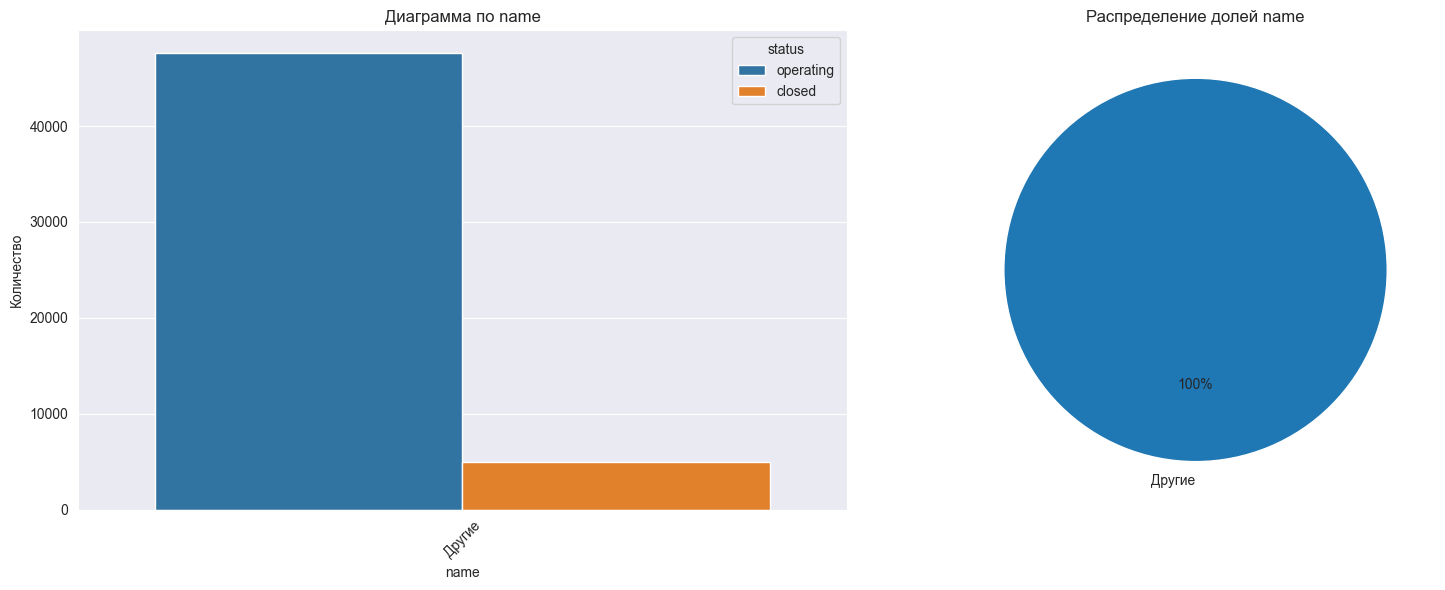

Визуализация категориального признака: category_list


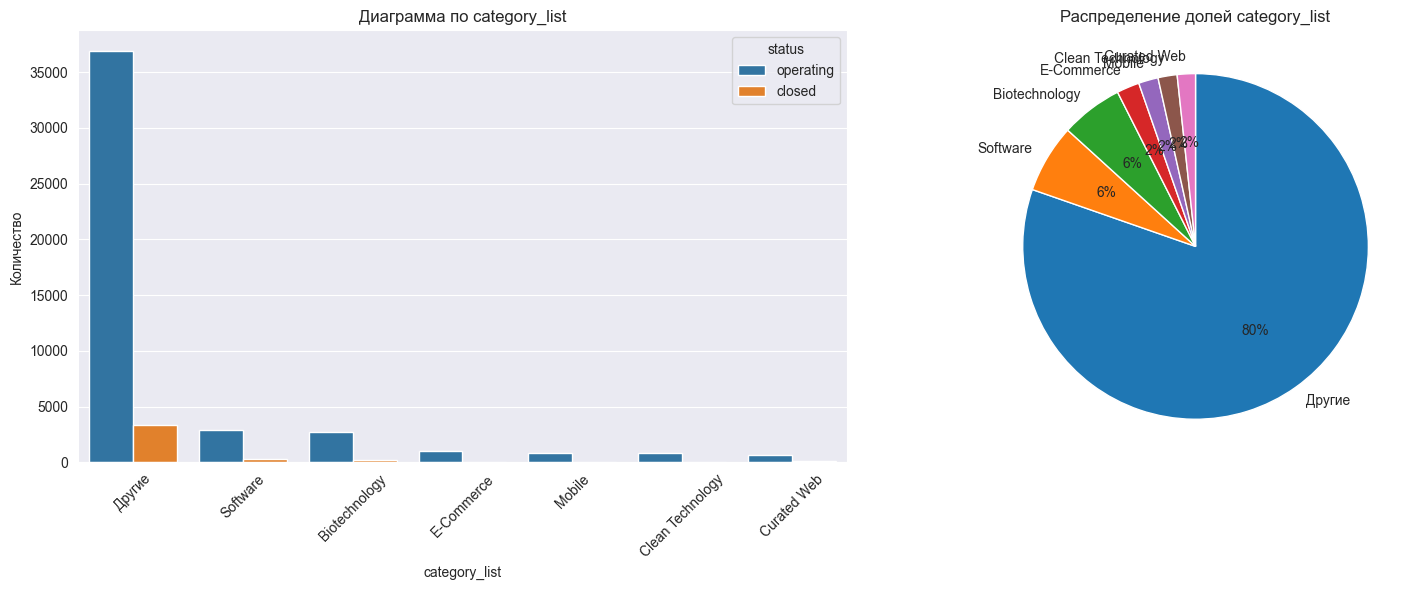

Визуализация категориального признака: status


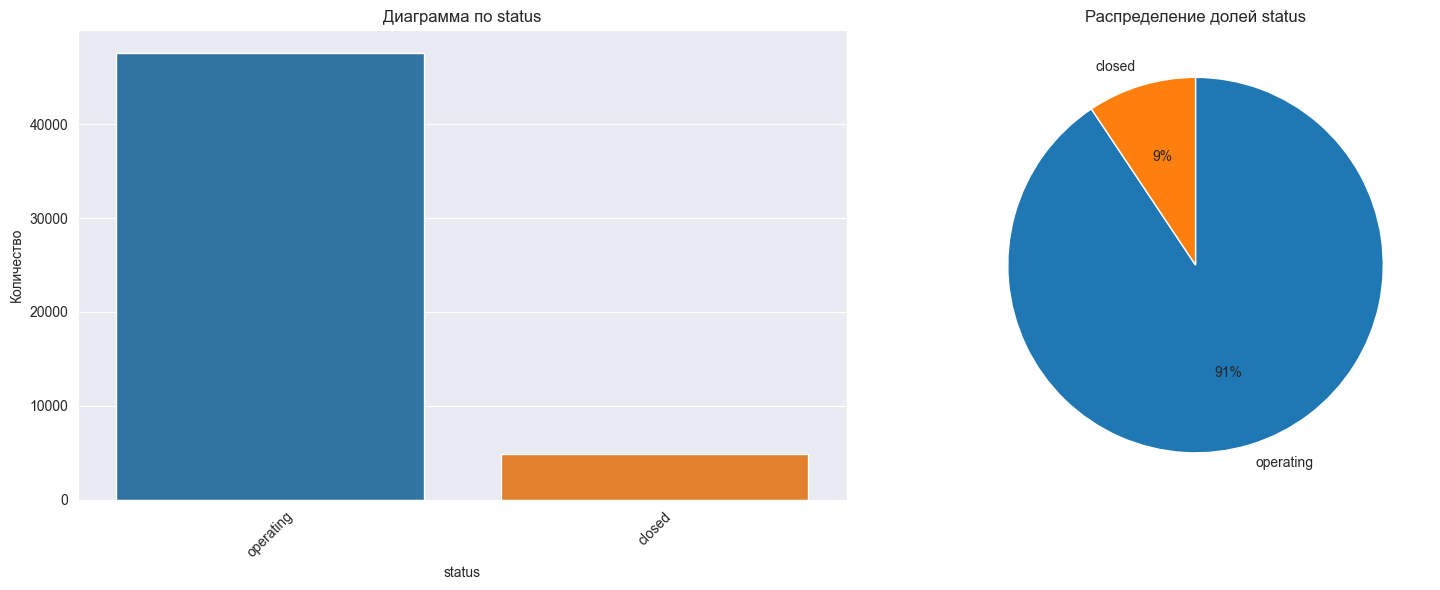

Визуализация категориального признака: country_code


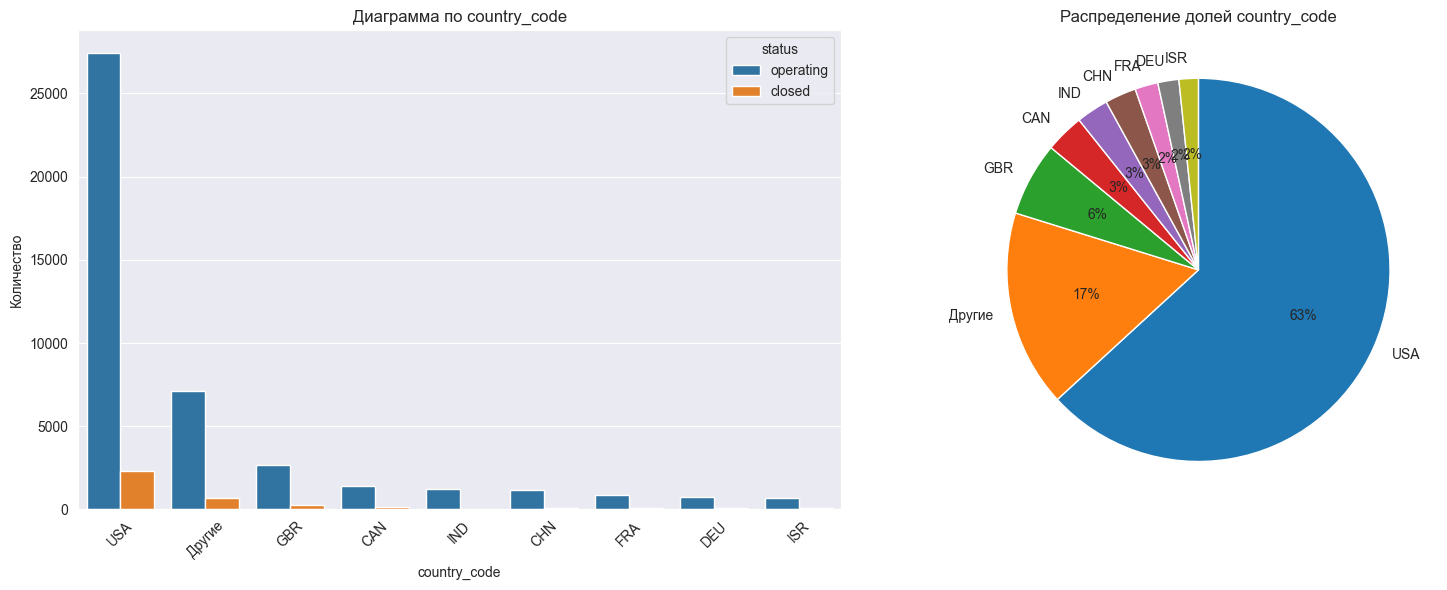

Визуализация категориального признака: state_code


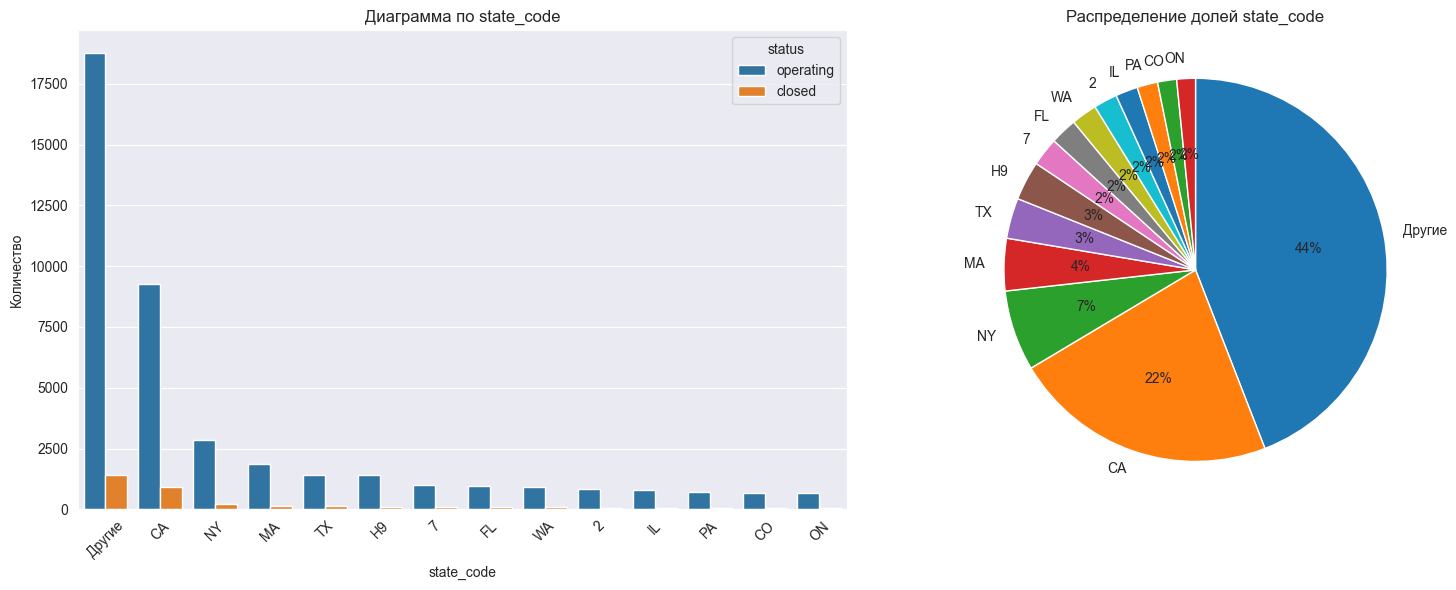

Визуализация категориального признака: region


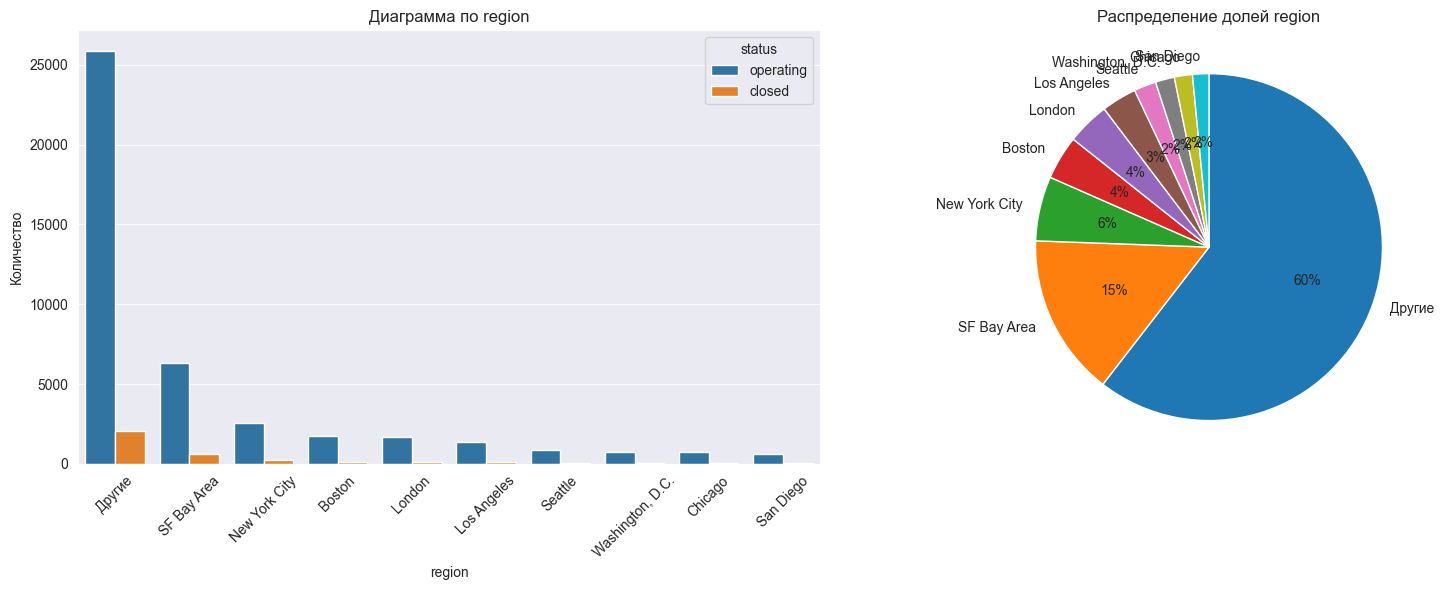

Визуализация категориального признака: city


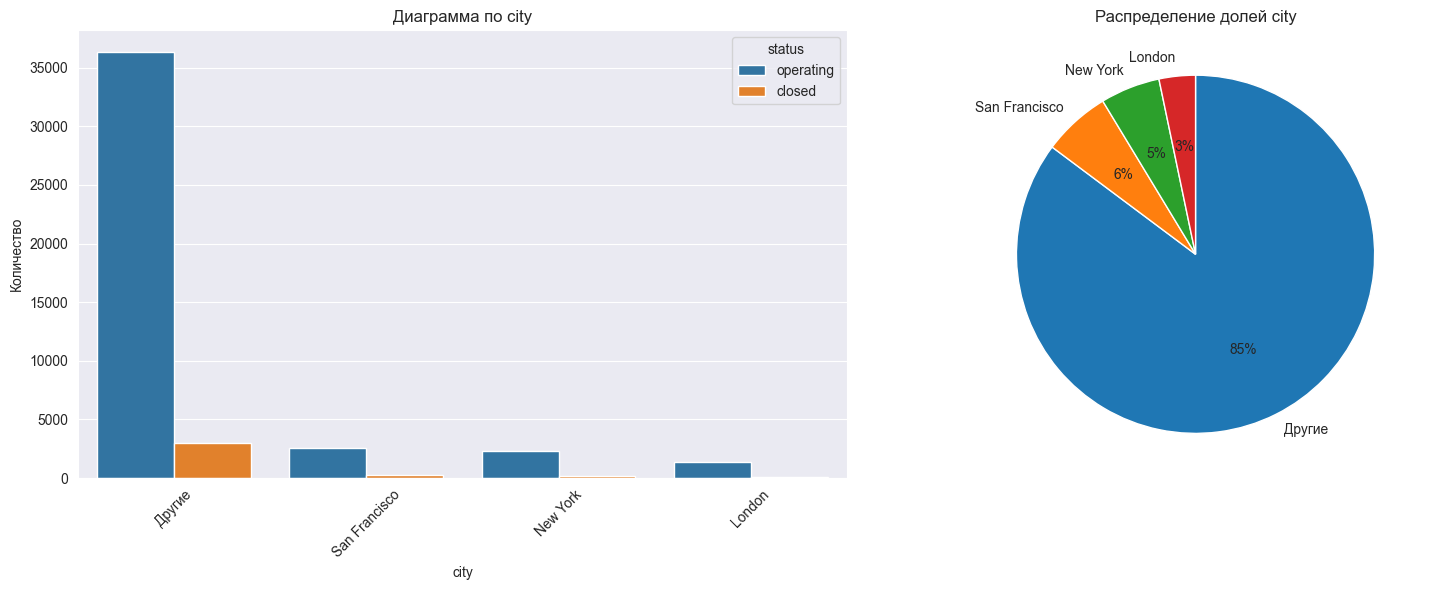

Визуализация категориального признака: end_cat


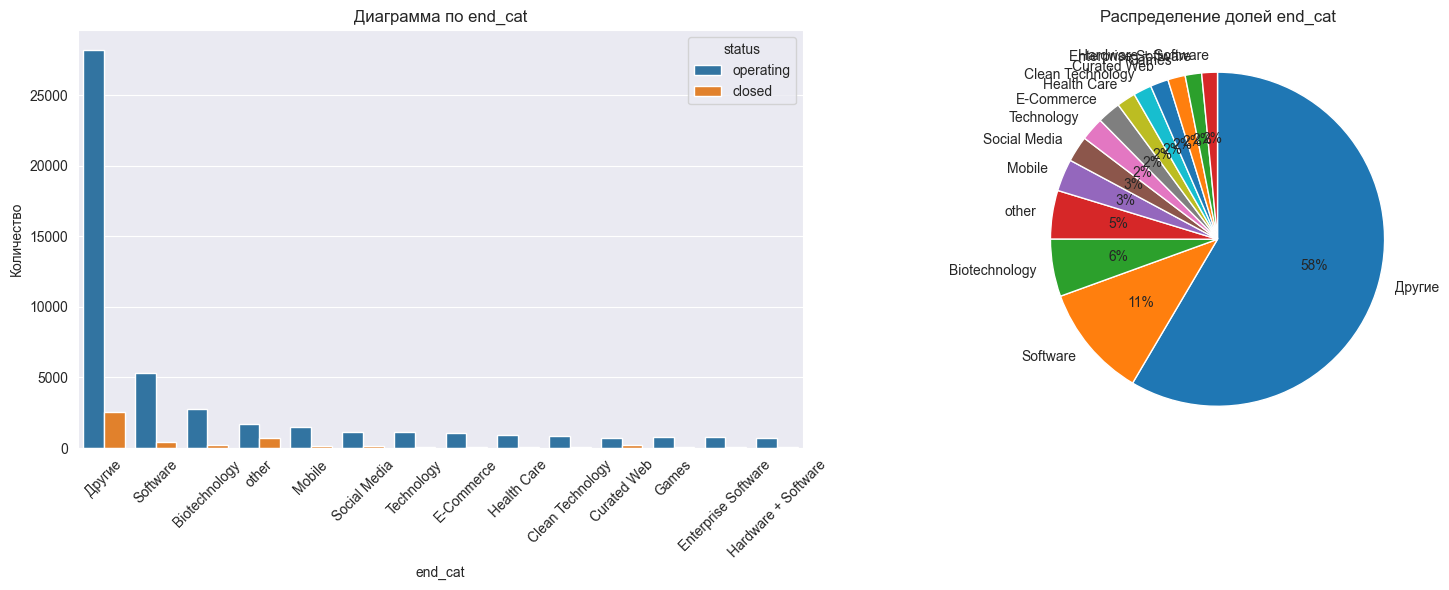

Визуализация категориального признака: root_cat


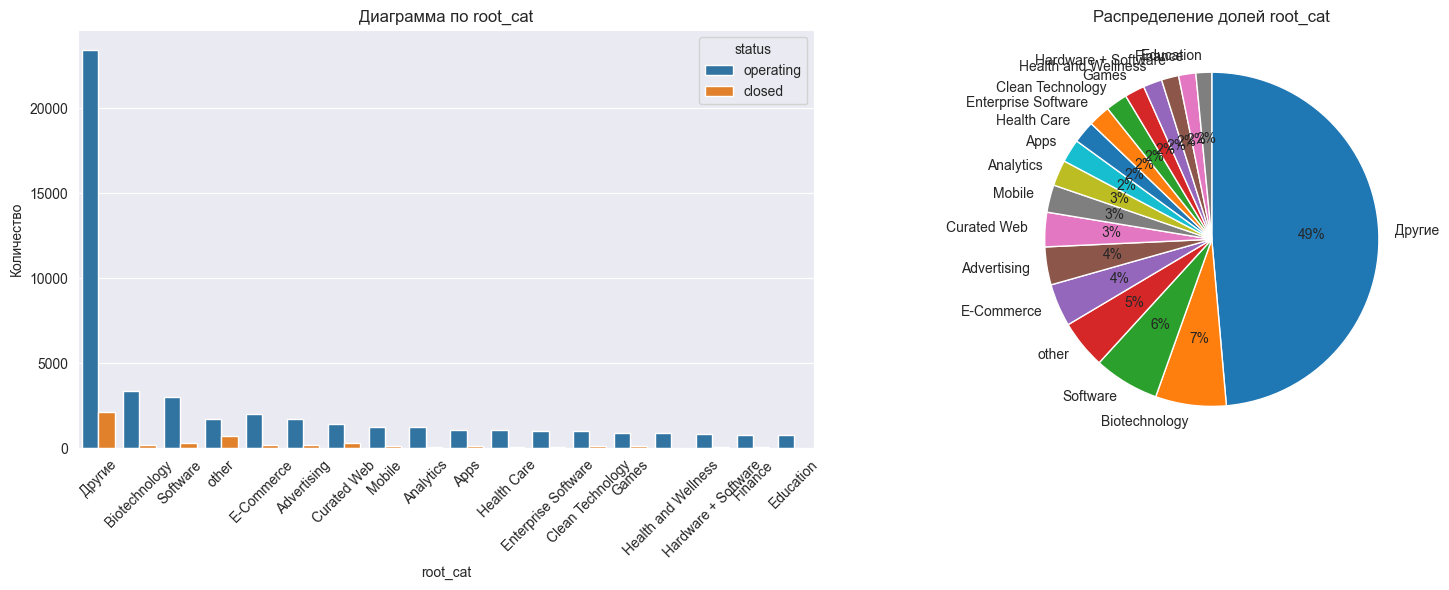

In [329]:
# Визуализируем признаки
all_diag(train, column_type='categorical', hue='status')

При построении графиков значения категориальных признаков занимающие менее 1,5% были собюраны в категорию 'Другие' для лучшей визуализации

- name - все значения уникальны, что ожидаемо
- status - целевой признак, по графику мы видим сильный дисбаланс классов, только 9% из всех стартапов закрылись.
- country_code - основная страна регистрации стартапов - США с долей 63%, затем идут Великобритания и Канада с 6 и 3%.
- state_code - самый распространенный штат регистрации стартапов - Калифорния, за ним идут Нью-Йорк и Массачусетс
- region - самый популярные регион это Область Залива Сан-Франциско и Нью-Йорк с 15% и 6% соответственно
- city - Сан Франциско у нас город стартапов с 63% и Лондон на втором месте всего с 6%
- end-cat - В топе у нас программное обеспечение и биотехнологии
- root-cat - тут также лидирует програмное обеспечение и биотехнологии

- Распределение целевой переменной совпадает с распеределением всех признаков.

### 2.3. Анализ признаков с датами

In [425]:
# Создадим функцию для визуализации признаков дат
def date_diag(data, date_col, hue=None,
                          figsize=(12, 6)):

    df = data.copy()
    df['year'] = df[date_col].dt.year

    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=df,
        x='year',
        hue=hue,
        order=sorted(df['year'].unique())
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3)

    plt.title(f'Распределение данных по годам\n({date_col})')
    plt.xlabel('Год')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)

    if hue:
        plt.legend(
            title=hue,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0
        )

    plt.tight_layout()
    plt.show()

Визуализация категориального признака: founded_at


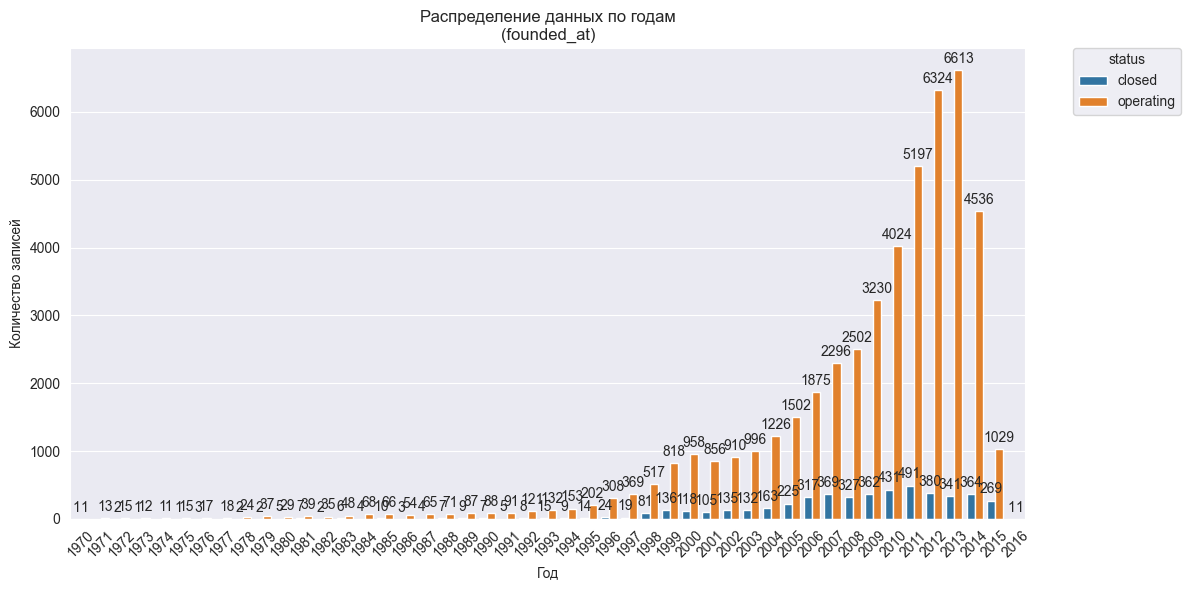

Визуализация категориального признака: first_funding_at


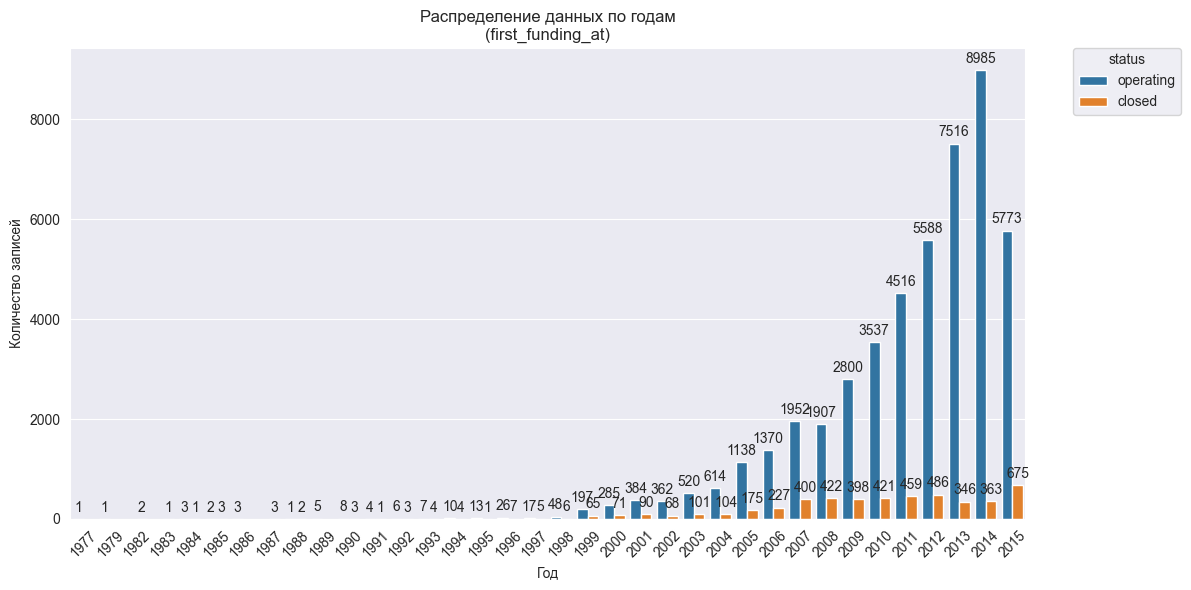

Визуализация категориального признака: last_funding_at


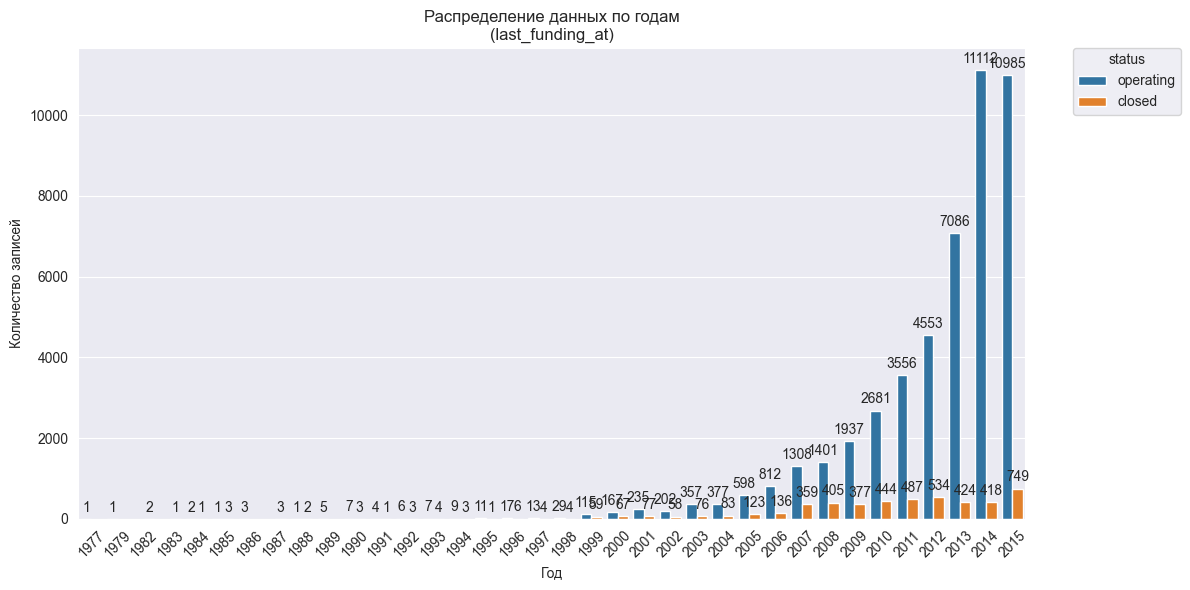

Визуализация категориального признака: closed_at


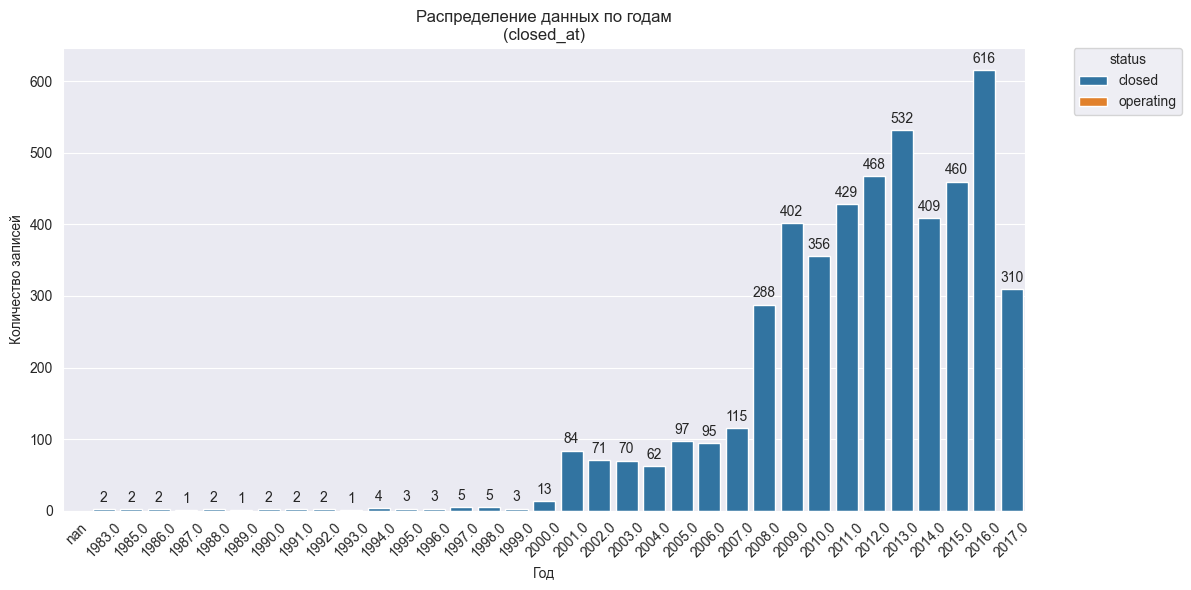

In [429]:
# Визуализируем даты
for date_col in date_cols:
    print(f"Визуализация категориального признака: {date_col}")
    date_diag(train, date_col, hue='status')

In [ ]:
- founded_at - большинство стартапов было основано с 2005 по 2014 год, также в эти периоды приходится основная часть закрытия стартапов. Количество закрытий напрямую с количеством открыти не коррелирует. Максимальное количетво закрытых стартапов было в 2011 году а максимальное количество открытых в 2013.
- first_funding_at - распределение дат первого раунда финансирования совпадают с распределеним с созданием стартапов. Максимальное количество стартапов прошедших первых раундов финансирования было в 2014 году.


## 2. Предобработка данных

Будем разбираться с каждой колонкой по отдельности по порядку в датасете train

### 2.1.name

В этой колонке у нас все значения уникальны, есть пропуски в одной строке.

In [330]:
# # Посмотрим на нее
# train[train['name'].isna()].head()

In [331]:
# # Заменим пропущенное значение на other
# train['name'] = train['name'].fillna('other')

### 2.2.category_list

В этой колонке у нас есть пропуски и в некоторых стартапах встречаются несколько категорий разделенных '|'.  Найдем все уникальные категории, и создадим для каждого отдельный столбец. Обозначим 1 если стартап в этой категории и 0 - если нет. Для пропущенных значений создадим категорию other. Попробывал все уникальные категории выделить столбцами, получилось около 800 столбцов. Думаю это слишком много. Буду выбирать только корневую категорию.

In [332]:
# # Приведем все категории к нижнему регистру
# train['category_list'] = train['category_list'].str.lower()

In [333]:
# # Заполним пропуски other
# train['category_list'] = train['category_list'].fillna('other')

In [334]:
# # Разделим строки по разделителю и выбираем корневую категорию
# split_categories = train['category_list'].str.split('|')

# # Создадим бинаризатор
# mlb = MultiLabelBinarizer()

# # Применяем и создадим датафрейм с полученными категориями
# categories = pd.DataFrame(mlb.fit_transform(split_categories),
#                          columns=mlb.classes_,
#                          index=train.index)
#
# # Объединяем с исходными данными
# train = pd.concat([train, categories], axis=1)

In [335]:
# # Проверим размер полученного датасета
# train.shape

### 2.3.funding_total_usd

В этой колонке мы можем заменить тип на int т.к. это сумма финансирования в долларах, суммы большие поэтому центы в сумме ни на что не повлияют. Также в колонке есть пропуски, возможно это связано с тем, что компании просто не получали финансирования а использовали свои средства, поэтому заменим пропуски нулями.

In [336]:
# # Заменим пропуски на 0
# train['funding_total_usd'] = train['funding_total_usd'].fillna(0)

In [337]:
# # Заменим тип данных на int
# train['funding_total_usd'] = train['funding_total_usd'].astype(int)

### 2.4.country_code, state_code, region, city

В этих колонках присутствуют пропуски. Заменим их на other

In [338]:
# # Шаг 1: Заполнить city по комбинации ИМЕЮЩИХСЯ данных в других колонках
# def fill_city_strategy(df):
#     # Создаем временный датафрейм без пропусков для анализа
#     valid_data = df.dropna(subset=['city'])
#
#     # Приоритет 1: По связке country_code + state_code + region (если все 3 известны)
#     if len(valid_data) > 0:
#         top_combo = valid_data.groupby(['country_code', 'state_code', 'region'])['city'] \
#                             .apply(lambda x: x.mode()[0] if len(x) > 0 else None) \
#                             .dropna() \
#                             .to_dict()
#
#         # Применяем заполнение
#         df['city'] = df.apply(
#             lambda row: top_combo.get(
#                 (row['country_code'], row['state_code'], row['region']),
#                 row['city']
#             ) if pd.notna(row['country_code']) and pd.notna(row['state_code']) and pd.notna(row['region']) else row['city'],
#             axis=1
#         )
#
#     # Приоритет 2: По связке country_code + state_code
#     if len(valid_data) > 0:
#         top_state = valid_data.groupby(['country_code', 'state_code'])['city'] \
#                             .apply(lambda x: x.mode()[0] if len(x) > 0 else None) \
#                             .dropna() \
#                             .to_dict()
#
#         df['city'] = df.apply(
#             lambda row: top_state.get(
#                 (row['country_code'], row['state_code']),
#                 row['city']
#             ) if pd.notna(row['country_code']) and pd.notna(row['state_code']) else row['city'],
#             axis=1
#         )
#
#     # Приоритет 3: По country_code (самый популярный город в стране)
#     if len(valid_data) > 0:
#         top_country = valid_data.groupby('country_code')['city'] \
#                               .apply(lambda x: x.mode()[0] if len(x) > 0 else None) \
#                               .dropna() \
#                               .to_dict()
#
#         df['city'] = df.apply(
#             lambda row: top_country.get(row['country_code'], row['city'])
#             if pd.notna(row['country_code']) else row['city'],
#             axis=1
#         )
#
#     return df
#
# # Применяем стратегию
# train = fill_city_strategy(train)

In [339]:
# train.isna().sum()

In [340]:
# train.head()

In [341]:
# train['city'] = train['city'].str.lower()
# cities['city'] = cities['city'].str.lower()

In [342]:
# print(train['city'].dtype)
# print(cities['city'].dtype)

In [343]:
# missing = train[~train['city'].isin(cities['city'])]
# print("Нет во втором датафрейме:", missing['city'].unique())

In [344]:
# print(train.shape)

In [345]:
# Присоединим к нашему датасету датасет с информацией о городах
# merged_data = train.join(
#     cities.set_index('city'),
#     on='city',
#     how='left'
# )

In [346]:
# print(train_merged.shape)

In [347]:
# Проверим что получилось
# train_merged.head()

In [348]:
# Удалим лишние столбцы
# country_code, state_code, region, city, city_ascii, iso2, iso3, id - удалим все названия городов, регионов и коды городов. Думаю названия никак не могут влиять на успешность стартапа.
# cols_drop = ['country_code', 'state_code', 'region', 'city']
# train_merged = train_merged.drop(columns=cols_drop)

In [349]:
# overview_data(train_merged)

### 2.5.founded_at, first_funding_at, last_funding_at, closed_at

В этих колонках не верный тип данных object вместо datetime. Изменим тип данных на верный. Также есть пропуски в колонке closed_at - думаю это означает то, что компания до сих пор существует. Также в датасете тест есть колонка lifetime которой нет в датасете train. Создадим ее как разницу между датой закрытия компании и датой основания.

In [350]:
# # Приведем все даты к нужному типу
# date_cols = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
# train[date_cols] = train[date_cols].apply(pd.to_datetime, errors='coerce')

In [351]:
# # Заполним пропуски в столбце closed_at текущей датой
# train['closed_at'] = train['closed_at'].fillna(pd.to_datetime(datetime.now().date()))

In [352]:
# # Создадим стобец lifetime
# train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

In [353]:
# # Удалим лишние столбцы после трансвформаций
# # Список столбцов для удаления
# columns_to_drop = ['category_list', 'founded_at', 'closed_at']
# train = train.drop(columns=columns_to_drop)

In [354]:
# date_cols2 = ['first_funding_at', 'last_funding_at']

In [355]:
# for col in date_cols2:
#     train[f'{col}_year'] = train[col].dt.year
#     train[f'{col}_month'] = train[col].dt.month
#     train[f'{col}_day'] = train[col].dt.day

### 2.4.country_code, state_code, region, city

In [356]:
# print("Распределение городов до заполнения:")
# print(train['city'].value_counts(normalize=True))

In [357]:
# # Шаг 1: Заполнить city по комбинации ИМЕЮЩИХСЯ данных в других колонках
# def fill_city_strategy(df):
#     # Создаем временный датафрейм без пропусков для анализа
#     valid_data = df.dropna(subset=['city'])
#
#     # Приоритет 1: По связке country_code + state_code + region (если все 3 известны)
#     if len(valid_data) > 0:
#         top_combo = valid_data.groupby(['country_code', 'state_code', 'region'])['city'] \
#                             .apply(lambda x: x.mode()[0] if len(x) > 0 else None) \
#                             .dropna() \
#                             .to_dict()
#
#         # Применяем заполнение
#         df['city'] = df.apply(
#             lambda row: top_combo.get(
#                 (row['country_code'], row['state_code'], row['region']),
#                 row['city']
#             ) if pd.notna(row['country_code']) and pd.notna(row['state_code']) and pd.notna(row['region']) else row['city'],
#             axis=1
#         )
#
#     # Приоритет 2: По связке country_code + state_code
#     if len(valid_data) > 0:
#         top_state = valid_data.groupby(['country_code', 'state_code'])['city'] \
#                             .apply(lambda x: x.mode()[0] if len(x) > 0 else None) \
#                             .dropna() \
#                             .to_dict()
#
#         df['city'] = df.apply(
#             lambda row: top_state.get(
#                 (row['country_code'], row['state_code']),
#                 row['city']
#             ) if pd.notna(row['country_code']) and pd.notna(row['state_code']) else row['city'],
#             axis=1
#         )
#
#     # Приоритет 3: По country_code (самый популярный город в стране)
#     if len(valid_data) > 0:
#         top_country = valid_data.groupby('country_code')['city'] \
#                               .apply(lambda x: x.mode()[0] if len(x) > 0 else None) \
#                               .dropna() \
#                               .to_dict()
#
#         df['city'] = df.apply(
#             lambda row: top_country.get(row['country_code'], row['city'])
#             if pd.notna(row['country_code']) else row['city'],
#             axis=1
#         )
#
#     return df
#
# # Применяем стратегию
# train = fill_city_strategy(train)

In [358]:
# train.head()

In [359]:
# most_common_city = train['city'].mode()[0]

In [360]:
# print(most_common_city)

In [361]:
# print("Распределение городов до заполнения:")
# print(train['city'].value_counts(normalize=True))

In [362]:
# train['city'] = train['city'].fillna(most_common_city)

In [363]:
# print("Распределение городов после заполнения:")
# print(train['city'].value_counts(normalize=True))

In [364]:
# train['city'] = train['city'].str.lower()
# cities['City'] = cities['City'].str.lower()

In [365]:
# cities[cities['City'].str.contains('cayman', case=False, na=False)].head()

In [366]:
# cities.head()

In [367]:
# missing = train[~train['city'].isin(cities['City'])]
# print("Нет во втором датафрейме:", missing['city'].unique())

In [368]:
# freq_table = missing['city'].value_counts(dropna=False)
# print("Распределение городов:")
# print(freq_table)

In [369]:
# train['city'] = train['city'].replace('são paulo', 'sao paulo')
# train['city'] = train['city'].replace('zürich', 'zurich')
# train['city'] = train['city'].replace('mexico city', 'mexico')
# train['city'] = train['city'].replace('reykjavík', 'reykjavik')
# train['city'] = train['city'].replace('bogotá', 'bogota')
# train['city'] = train['city'].replace('asunción', 'asuncion')
# train['city'] = train['city'].replace('lomé', 'lome')
# train['city'] = train['city'].replace('st. peter port', 'saint peter port')
# train['city'] = train['city'].replace('grand cayman', 'caymanas')


In [370]:
# # Присоединим к нашему датасету датасет с информацией о городах
# train_merged = train.join(
#     cities.set_index('City'),
#     on='city',
#     how='left'
# )

In [371]:
# # Удалим лишние столбцы
# # country_code, state_code, region, city, city_ascii, iso2, iso3, id - удалим все названия городов, регионов и коды городов. Думаю названия никак не могут влиять на успешность стартапа.
# cols_drop = ['country_code', 'state_code', 'region', 'city']
# train_merged = train_merged.drop(columns=cols_drop)

In [372]:
# overview_data(train_merged)

In [373]:
# train_merged.shape

## 3.Анализ признаков

In [374]:
# # Создадим датасет для анализа признаков без бинаризированных
# train_b = train.drop(columns=categories.columns).copy()
# train_b = train_b.drop(columns='name')

In [375]:
# train_b.head()

In [376]:
# # Функция построения диаграмм для числовых признаков
# def num_diag(data, x, xlabel, ylabel, hue=None):
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#
#     sns.histplot(
#         data=data,
#         x=x,
#         hue=hue,
#         ax=axes[0],
#         stat="density",
#         common_norm=False
#     )
#     axes[0].set_title(f'Гистограмма по {xlabel}')
#     axes[0].set_xlabel(xlabel)
#     axes[0].set_ylabel(ylabel)
#
#     sns.boxplot(
#         data=data,
#         x=x,
#         ax=axes[1]
#     )
#     axes[1].set_title(f'Диаграмма размаха {xlabel}')
#     axes[1].set_xlabel(xlabel)
#     axes[1].set_ylabel(ylabel)
#
#     plt.tight_layout()
#     plt.show()

In [377]:
# # Функция построения диаграмм для категориальных признаков
# def cat_diag(data, x, xlabel, hue=None):
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#
#     sns.countplot(
#         data=data,
#         x=x,
#         hue=hue,
#         ax=axes[0]
#     )
#     axes[0].set_title(f'Диаграмма по {xlabel}')
#     axes[0].set_ylabel('Количество')
#     axes[0].set_xlabel(xlabel)
#     axes[0].tick_params(axis='x', rotation=45)
#
#     data[x].value_counts(normalize=True).plot(
#         kind='pie',
#         labels=data[x].value_counts(normalize=True).index,
#         legend=False,
#         autopct='%1.0f%%',
#         ax=axes[1]
#     )
#     axes[1].set_title(f'Распределение долей {xlabel}')
#     axes[1].set_ylabel('')
#
#     plt.tight_layout()
#     plt.show()

In [378]:
# # Создадим функцию для автоматической визуализации признаков в зависимости от типа колонки
# def all_diag(df, column_type='numeric', hue=None):
#     if column_type == 'numeric':
#         columns = df.select_dtypes(include='number').columns
#     elif column_type == 'categorical':
#         columns = df.select_dtypes(include='object').columns
#
#     for col in columns:
#         if column_type == 'numeric':
#             print(f"Визуализация численного признака: {col}")
#             num_diag(df, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
#         elif column_type == 'categorical':
#             print(f"Визуализация категориального признака: {col}")
#             cat_diag(df, x=col, xlabel=col, hue=hue)

### 3.1.Анализ числовых признаков

In [379]:
# all_diag(train_b, column_type='numeric', hue=None)

### 3.2.Анализ категориальных признаков

In [380]:
# all_diag(train_b, column_type='categorical', hue=None)

## 4. Корреляционный анализ

In [381]:
# # Построим матрицу корреляции между признаками в датасете train_b
# train_b = train_b.drop(columns=date_cols2)

In [382]:
# train_b = train_b.select_dtypes(include='number')  # перезаписываем датафрейм, оставляя только числа
# display(train_b.corr('spearman'))

In [383]:
# train_b.head()

In [384]:
# # Cоздадим матрицу корреaляции phik
# phk = train_b.phik_matrix(verbose=False, interval_cols=['funding_total_usd', 'lifetime'])

In [385]:
# # Визуализируем матрицу корреляции
# plt.figure(figsize=(12, 8))
# plt.title('Матрица корреляции')
# sns.heatmap(phk, annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()

In [386]:
# # Добавим константу
# df_with_const = add_constant(train_b)

In [387]:
# # Определим функцию подсчета VIF
# def calc_vif(df):
#
#     vif_data = pd.DataFrame()
#     vif_data["variables"] = df.columns
#     vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
#
#     return vif_data

In [388]:
# # Рассчитаем VIF
# calc_vif(train_b)

Ключевые пороги для VIF:
- VIF < 5: Минимальная мультиколлинеарность, это нормально.
- 5 ≤ VIF ≤ 10: Признак умеренной мультиколлинеарности, стоит обратить внимание.
- VIF > 10: Сильная мультиколлинеарность, вероятно, данные коррелируют с другими, стоит рассмотреть их исключение или трансформацию.

## 5. Зависимости признаков

## 6. Моделирование

In [389]:
# train.head()

In [390]:
# encoder = TargetEncoder()
# train = encoder.fit_transform(train, train['status'])

In [391]:
# train.head()